In [1]:
import os
import matplotlib.pyplot as plt
import copy

import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv("/kaggle/input/nlpinno/train.csv")
print(train.shape)
train.sample(5)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
232843,232843,210893,342948,Who serves a princess or queen? Do they have r...,"In the song ""Hope I don't fall in love with yo...",0
13693,13693,19999,26274,Should people over 99 not be allowed to vote?,Should people over 91 not be allowed to vote?,1
313635,313635,438237,438238,What do you think about Supreme Court justices...,Is there a reason why a new end of the world t...,0
69958,69958,120657,83108,What's the difference between psychiatrist and...,Is there a difference between psychiatrist and...,1
198201,198201,159248,299345,What is the worst thing that happened to you a...,What is the worst thing that happened to you a...,0


In [3]:
print(train.isnull().sum().sum())
train.info()

3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
train = train[~train.isna().any(axis=1)]
print(train.isnull().sum().sum())
train.info()

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [5]:
train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
train.sample(5)

,question1,question2,is_duplicate
2115,Why is Snapchat currently more or less success...,How is Snapchat valued more than Twitter?,0
190609,How do i (a Java developer) get an Adobe Exper...,What would be our learning curve as a consulta...,0
333851,What is better to use: MIT OCW or Khan Academy?,"Between Khan academy and MIT OCW, which is bet...",1
58778,Can I insert my signature at the end of my Quo...,Can I put a signature at the bottom of my Quor...,1
369031,Could the universe be the brain of a godly cre...,Could the universe be a colossal self aware br...,0


In [6]:
test = pd.read_csv("/kaggle/input/question-pairs-dataset/questions.csv")
print(test.shape)
test.tail(5)

(404351, 6)


,id,qid1,qid2,question1,question2,is_duplicate
404346,404346,789792,789793,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404347,404347,789794,789795,Do you believe there is life after death?,Is it true that there is life after death?,1
404348,404348,789796,789797,What is one coin?,What's this coin?,0
404349,404349,789798,789799,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404350,404350,789800,789801,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


# Reading data as Huggingface dataset object

In [7]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=1, shuffle=False)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)

In [8]:
dataset = load_dataset('csv', data_files={'train': 'train_clean.csv',\
                                          'valid':'val_clean.csv'},)
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c4cefccf9d79ac0b/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 323429
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 80858
    })
})

In [9]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Sample Tokenization

In [11]:
tokenizer(train.question1[0], train.question2[0], 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=100,  
                                      return_tensors='tf',return_token_type_ids = True)  # Return torch.Tensor objects

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106,
        17557,  1107,  2934,  2319,  1107,  1107,  7168,   136,   102,
         1327,  1110,  1103,  2585,  1118,  2585,  6388,  1106, 17557,
         1107,  2934,  2319,   136,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Tokenizer for Model Training

In [12]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [13]:
pre_tokenizer_columns = set(dataset["train"].features)

In [14]:
pre_tokenizer_columns

{'is_duplicate', 'question1', 'question2'}

In [15]:
encoded_dataset = dataset.map(preprocess_function, batched=True, )

  0%|          | 0/324 [00:00<?, ?ba/s]

  0%|          | 0/81 [00:00<?, ?ba/s]

In [16]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 323429
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 80858
    })
})

In [17]:
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['token_type_ids', 'input_ids', 'attention_mask']


# Data padding and batching

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
# sample train batch
z = next(iter(tf_train_dataset))

In [20]:
# sample decoded string
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] Why is HBO drama The Newsroom being canceled after the third season? [SEP] Do you think that Sleepy Hollow ( TV series ) will be cancelled after season 4? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [21]:
# Number of classes in the classification task
num_labels = train.is_duplicate.nunique()
num_labels

2

# Loading the model checkpoint


In [22]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Hyperparameters

In [23]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

# Closer look at the learning rate scheduler

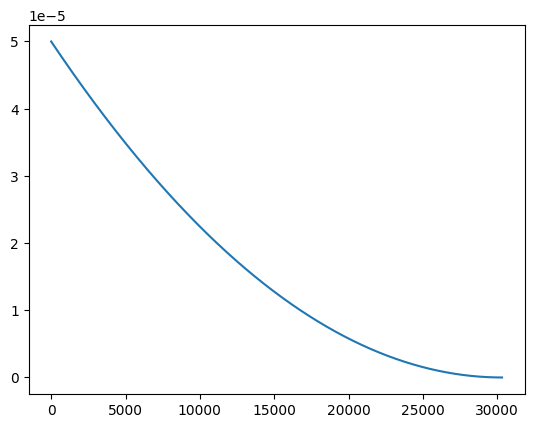

In [24]:
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)

In [25]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [26]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=1)

10107/10107 [==============================] - 4711s 461ms/step - loss: 0.3108 - accuracy: 0.8608 - val_loss: 0.2535 - val_accuracy: 0.8928


In [45]:
def check_similarity(question1, question2, debug = 0):
  tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length = 75, return_tensors = 'tf')
  logits = model(**tokenizer_output)["logits"]
  predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
  if predicted_class_id == 1:
    if(debug):
        print("SAME")
    return 1
  else:
    if(debug):
        print("DIFFERENT")
    return 0


In [46]:
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?", 1)

DIFFERENT


0

In [47]:
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?", 1)

SAME


1

In [48]:
check_similarity("I am Maitri's BestFriend", "Maitri is my BestFriend", 1)

SAME


1